# Super resolution of depth image using RGB image

Based on http://ieeexplore.ieee.org.sci-hub.io/document/7362701/

First, let's do some imports.

In [2]:
#imports
import cv2
import sys
import numpy as np
import numpy.random
import scipy.sparse as sp
import scipy.sparse.linalg
import PIL.Image
from io import BytesIO
import IPython.display
import numpy as np

def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))
numpy.set_printoptions(linewidth=1000000)

Let's define some parameters: the size of image we want to work with, and a scaling factor for display

In [3]:
#params
sz = 300
zoom = 5

Load the images. Resize them. Convert them to greyscale. Convert them to float.

From now on, we can work with `img` and `depth`, which have values from 0 to 255

img
[[ 156.52666666  156.91000001  157.58333343 ...,   84.23331296   83.78998411   85.73999022]
 [ 156.82333333  156.70000005  157.         ...,   82.83331299   81.69997561   83.45327153]
 [ 157.65000001  156.64999998  157.41666675 ...,   84.5          84.70001221   82.2833252 ]
 ..., 
 [  76.65000001   72.94999993   72.         ...,   41.9168396    56.54995728   62.93334961]
 [  73.86666667   71.7600037    71.85000116 ...,   40.40016276   57.09994507   62.2900059 ]
 [  73.56332805   72.79000853   72.70001221 ...,   40.30010986   55.07994873   59.9033256 ]]


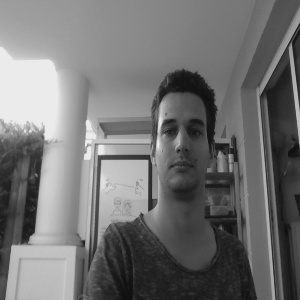

depth
[[ 188.  184.  176. ...,  198.  201.  203.]
 [ 186.  182.  175. ...,  197.  200.  202.]
 [ 181.  177.  172. ...,  196.  198.  199.]
 ..., 
 [ 186.  183.  180. ...,  207.  209.  211.]
 [ 193.  191.  188. ...,  208.  211.  213.]
 [ 197.  195.  190. ...,  208.  212.  214.]]


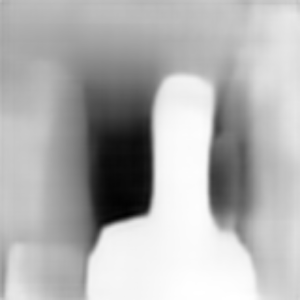

In [6]:
# load images
img = cv2.imread("./img.png")
depth = cv2.imread("./depth.png")

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = img.astype(float)

depth = cv2.cvtColor(depth, cv2.COLOR_BGR2GRAY)

img = cv2.resize(img, (sz, sz))
depth = cv2.resize(depth, (sz, sz)).astype(float)
i_depth = depth.copy()

M, N = img.shape

print("img")
print(img)
showarray(img)

print("depth")
print(depth)
showarray(depth)

Make the D matrix.

D is the vertical AND horizontal difference operator.

`D.dot(img)` outputs the horizontal flattened image in `[:M * N - M]` and the vertical difference image in `[M * N - M:]`

In [7]:
def make_D(M, N):
    u = sp.diags([[1] * (M - 1), [-1] * (M - 1)], [0, 1], shape=(M - 1, M))
    U = sp.block_diag([u] * N)

    V = sp.diags(
        [[1] * (M * (N - 1)), [-1] * (M * (N - 1))], [0, M],
        shape=(M * (N - 1), M * N))
    return sp.hstack([U.T, V.T]).T


D = make_D(M, N)
print('D done', D.shape, D.size)

('D done', (179400, 90000), 358800)


Create `dx` and `dy`, the reshaped and rescaled difference images, used only for display

('d_img done', (179400,), 179400)
[-0.38333335 -0.67333342  0.58333343 ...,  0.1000529   2.01999634  2.3866803 ]
dx
[[ 123.7541833   123.46061487  124.73274461 ...,  123.88243496  124.59101732  122.16823313]
 [ 124.2670843   123.83854209  124.14223345 ...,  125.29291444  125.28951618  122.36736378]
 [ 125.15453816  123.36613309  123.55172246 ...,  124.12536582  123.93976015  126.58865702]
 ..., 
 [ 127.88776084  125.10392282  126.62237996 ...,  113.24287426  109.32905994  117.68029551]
 [ 126.27481823  124.0511286   125.95088592 ...,  113.75578847  107.23696566  118.88831057]
 [ 124.92506841  124.23333714  126.84172498 ...,  113.91779553  109.18053339  119.25950646]]


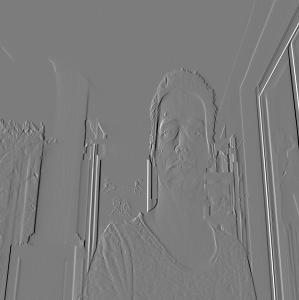

dy
[[ 124.35351173  124.95584212  125.3996647  ...,  126.37052611  127.19081519  127.42466624]
 [ 123.72344238  124.76563263  124.21085442 ...,  122.72481775  121.13971835  126.09703602]
 [ 123.64022582  122.98241754  123.10129833 ...,  125.16187107  128.18936051  122.53049041]
 ..., 
 [ 126.86585639  125.47891856  125.59779372 ...,  126.78664594  125.88309805  124.06026683]
 [ 128.01504672  126.12087154  124.88451218 ...,  126.50923274  124.05236102  125.47100552]
 [ 125.06680406  123.48171194  123.69569036 ...,  124.82513594  127.10758402  127.5435016 ]]


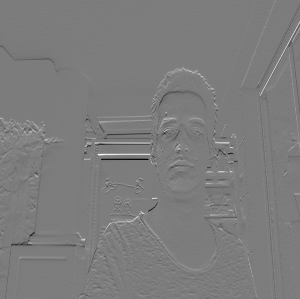

In [10]:
d_img = D.dot(img.flatten())
print('d_img done', d_img.shape, d_img.size)
print(d_img)

dx = d_img[:M * N - M].reshape(M, N - 1)
dx = (dx - dx.min()) / (dx.max() - dx.min()) * 255


dy = d_img[M * N - M:].reshape(M - 1, N)
dy = (dy - dy.min()) / (dy.max() - dy.min()) * 255


print("dx")
print(dx)
showarray(dx)
print("dy")
print(dy)
showarray(dy)

Create the `F` operator which is a pixel wise division comparison with the derivative of `img`.

Then, Create the `FD` operator which derives its input and compares is with the derivative of `img`

In [11]:
F = sp.diags([1.0/(np.abs(d_img) + 1e-8)], [0])
print('F done', F.shape, F.size)
#del d_img

FD = F.dot(D)
print('FD done', FD.shape, FD.size)
print(FD)

('F done', (179400, 179400), 179400)
('FD done', (179400, 90000), 358800)
  (0, 1)	-2.60869548947
  (0, 0)	2.60869548947
  (1, 2)	-1.48514829296
  (1, 1)	1.48514829296
  (2, 3)	-1.71428538712
  (2, 2)	1.71428538712
  (3, 4)	-2.17391736799
  (3, 3)	2.17391736799
  (4, 5)	-0.449102032262
  (4, 4)	0.449102032262
  (5, 6)	-1.30434824174
  (5, 5)	1.30434824174
  (6, 7)	-6.66666595731
  (6, 6)	6.66666595731
  (7, 8)	-2.45901578514
  (7, 7)	2.45901578514
  (8, 9)	-2.05479440451
  (8, 8)	2.05479440451
  (9, 10)	-2.27272537793
  (9, 9)	2.27272537793
  (10, 11)	-2.70270060075
  (10, 10)	2.70270060075
  (11, 12)	-100000000.0
  (11, 11)	100000000.0
  (12, 13)	-2.04081732256
  :	:
  (179387, 89687)	0.666687459925
  (179388, 89988)	-1.35746154576
  (179388, 89688)	1.35746154576
  (179389, 89989)	-0.308638892846
  (179389, 89689)	0.308638892846
  (179390, 89990)	-1.33927000483
  (179390, 89690)	1.33927000483
  (179391, 89991)	-1.71440228498
  (179391, 89691)	1.71440228498
  (179392, 89992)	-1.1764198

# Doing the actual thing

This is where it starts to get messy.

First, I create a `C` matrix (like "constraints") which does a random sampling of pixels in the image. It's an identity matrix with most 1s on the diagonal changed to 0.

`lam` is a hyper parameters meant to choose whether we favor flattening the gradient of the generated image or staying as close as possible to the sampled pixel values.

The objective function is

$$ \underset{x}{\text{argmin}} \lVert{FDx}\rVert_2^2 + \lambda \lVert C(x - d) \rVert_2^2$$

If we want to make it really look like a least square minimization, we can rewrite it like this

$$ \underset{x}{\text{argmin}} \lVert FDx - 0 \rVert_2^2 + \lVert \lambda Cx - \lambda Cd \rVert_2^2 $$

And if we want only one squared term,

$$
\underset{x}{\text{argmin}}
\left \lVert
  (\begin{array}{c} FD \\ \lambda C \end{array})
  x -
  \begin{pmatrix} 0 \\ \lambda Cd \end{pmatrix}
\right \rVert_2^2
$$

Now, that looks like a $ \lVert Ax - b \rVert_2^2$ least square problem that can be solved with [scipy's LSQR](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.linalg.lsqr.html ) . This can be interpreted as "We want $x$ transformed by $A$ to look like $b$". In this case, it means, "We want the division of the depth gradient and the greyscale image gradient to be zero (which I don't understand, should be like a smoothing constraint and a similarity constraint), and the sampled pixels to remain unchanged in the result".

However, it doesn't work.

('A', (269400, 90000))
('b', (269400,))
('d', (90000,))
[ -9.84483297e-78  -6.58916424e-66  -2.52682215e-53 ...,   5.16959981e-23   4.15648681e-38   1.59712578e-52]
Difference


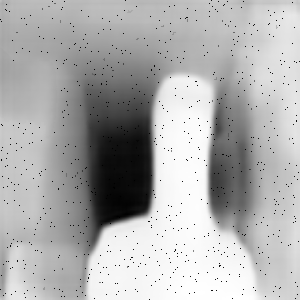

recovered depth
[  9.73590502e-90   9.84483297e-78   6.58916424e-66 ...,   4.52996448e-33   2.14746595e-48   5.88473255e-63]


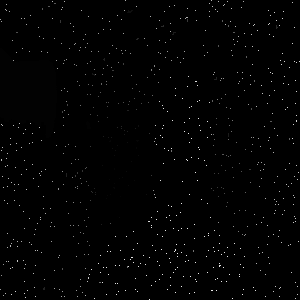

original depth


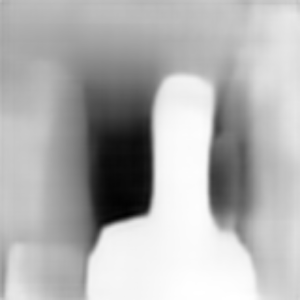

In [13]:
lam = 100

C = sp.identity(M * N).multiply(sp.diags([0 + (np.random.rand(M * N) < 0.01)], [0]))

A = sp.vstack([FD, lam * C])
b = np.hstack([np.zeros((2 * M * N - M - N, )), (lam * C).dot(depth.flatten())])
d = sp.linalg.lsqr(A, b)

print('A', A.shape)
print('b', b.shape)
print('d', d[0].shape)

d = d[0]

print(D.dot(d))

print("Difference")
showarray((depth - d.reshape(M, N)))

print("recovered depth")
print(d)
showarray(d.reshape(M, N))
print("original depth")
showarray(depth)

# From now on, this is just garbage and tests

In [ ]:
lam = 1

C = sp.identity(M * N).multiply(sp.diags([0 + (np.random.rand(M * N) < 0.01)], [0]))

A = sp.vstack([FD, lam * C])
b = np.hstack([np.zeros((2 * M * N - M - N, )), (lam * C).dot(depth.flatten())])
d = sp.linalg.lsqr(A, b)

for i in range(3):
    G = sp.diags([1.0/(np.abs(d) + - (1.0 / d_img.mean()))], [0])
    A = sp.vstack([FD, lam * C])
    b = np.hstack([np.zeros((2 * M * N - M - N, )), (lam * C).dot(depth.flatten())])
    d = sp.linalg.lsqr(A, b)

print(np.square(FD.dot(depth.flatten())).sum())
#print(np.square((lam * C).dot(depth.flatten()) - (lam * C.dot())).sum())
print('A', A.shape)
print('b', b.shape)
print('d', d[0].shape)
print(d[0])

d = d[0]

print(D.dot(d))

print("Difference")
showarray((depth - d.reshape(M, N)) * 255)

d -= d.min()
d /= d.max()

print("recovered depth")
print(d)
showarray(d.reshape(M, N) * 255)
print("original depth")
showarray(depth * 255)

[[ 238.          238.          232.33333333 ...,  232.33333333  232.33333333  232.33333333]
 [ 255.          255.          243.66666667 ...,  232.33333333  238.          243.66666667]
 [ 255.          249.33333333  249.33333333 ...,  232.33333333  238.          243.66666667]
 ..., 
 [ 175.66666667  181.33333333  181.33333333 ...,  215.33333333  215.33333333  215.33333333]
 [ 187.          181.33333333  181.33333333 ...,  221.          215.33333333  215.33333333]
 [ 204.          204.          215.33333333 ...,  226.66666667  221.          221.        ]]


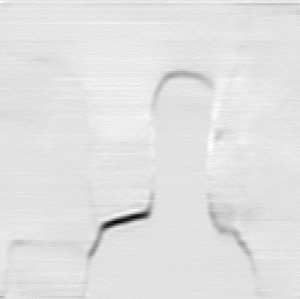

[[ 124.35351173  124.95584212  125.3996647  ...,  126.37052611  127.19081519  127.42466624]
 [ 123.72344238  124.76563263  124.21085442 ...,  122.72481775  121.13971835  126.09703602]
 [ 123.64022582  122.98241754  123.10129833 ...,  125.16187107  128.18936051  122.53049041]
 ..., 
 [ 126.86585639  125.47891856  125.59779372 ...,  126.78664594  125.88309805  124.06026683]
 [ 128.01504672  126.12087154  124.88451218 ...,  126.50923274  124.05236102  125.47100552]
 [ 125.06680406  123.48171194  123.69569036 ...,  124.82513594  127.10758402  127.5435016 ]]


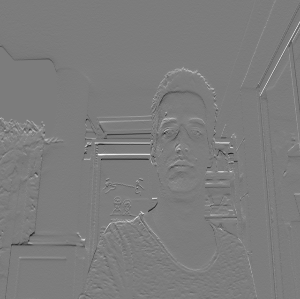

[[ 488.0441184   485.6915769   472.44942911 ...,  468.81976221  465.79621267  464.94137867]
 [ 525.56733589  521.17717537  500.23808537 ...,  482.74669366  500.99175422  492.75543629]
 [ 525.92107115  516.98447041  516.48521067 ...,  473.34703047  473.44022747  507.09827235]
 ..., 
 [ 353.0894858   368.50811699  368.15933331 ...,  433.0897753   436.1983527   442.60746331]
 [ 372.49527474  366.63241727  370.2620861  ...,  445.46155866  442.63567051  437.63098711]
 [ 415.93770939  421.27695821  443.9119895  ...,  463.04776331  443.36457524  441.84924588]]
(0.0, 2245.5110047210023, 462.9859956908445)


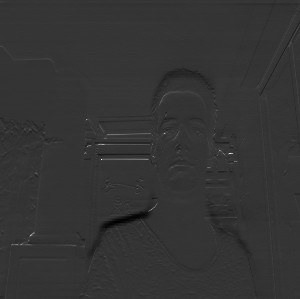

In [47]:
dyd = D.dot(depth.flatten())[M * N - M:].reshape(M - 1, N)
dyd = (dyd - dyd.min()) / (dyd.max() - dyd.min()) * 255
dy2 = dy
mask = np.abs(dy) <= 25
#dy2 += mask * 50
print(dyd)
showarray(dyd)
print(dy2)
showarray(dy)
q = dyd / (np.abs(dy2)) * 255
print(q)
print(q.min(), q.max(), q.mean())
showarray((q - q.min()) / (q.max() - q.min()) * 255 )